In [1]:
import pandas as pd
import os
datasetfname = os.path.join("input","datasets.xlsx")
datapath = os.path.join("central","groups","murray-biocircuits","ashur","nanopore")

readsname = "allreads.fastq"
outname = "simprec.py"

df_data = pd.read_excel(datasetfname,sheet_name="alldata",converters={"date_sequenced":str})
df_inducers = pd.read_excel(datasetfname,sheet_name="inducers",header=13)
df_inducers.columns = df_inducers.columns.astype(str)
df_seqs = pd.read_excel(datasetfname,sheet_name="sequences")

#layout
#            plasmid                    genome        
#================================---------------------------
#   [bc>  [u21r><attB]<plasbc]<attL]   <uintf] <rc(bc)]
#<barcode><prefixseq><variable_seq><postfixseq><rc(barcode)>
#<barcode><newplasmidend1><plasbc1><genomechunk><rc(barcode)>



In [4]:
df_data[df_data["date_sequenced"]=="201125"]

,date_sequenced,barcode,genome,int_control,plasmid1,plasmid2,primerf,primerr,c1,c2,c3,c4,see,prefix,variable1,variable2,suffix,note,int_inducer
150,201125,npbc1,NaN,REC49,i70,i71-2,UintF,chlorR,"1,[sal,atc,cin]","22,[sal,atc,cin]",NaN,NaN,2020-11-24,"[newplasmend2,newplasmend1]",plasbc2,plasbc1,genomechunk,NaN,sal
151,201125,npbc2,NaN,REC49,i70,i71-2,UintF,chlorR,"1,[sal,atc,ara]","22,[sal,atc,ara]",NaN,NaN,2020-11-24,"[newplasmend2,newplasmend1]",plasbc2,plasbc1,genomechunk,NaN,sal
152,201125,npbc3,NaN,REC49,i70,i71-2,UintF,chlorR,"1,[sal]","22,[sal,atc,cin]",NaN,NaN,2020-11-24,"[newplasmend2,newplasmend1]",plasbc2,plasbc1,genomechunk,NaN,sal
153,201125,npbc4,NaN,REC49,i70,i71-2,UintF,chlorR,"1,[sal]","22,[sal,atc,ara]",NaN,NaN,2020-11-24,"[newplasmend2,newplasmend1]",plasbc2,plasbc1,genomechunk,NaN,sal
154,201125,npbc5,NaN,REC49,i70,i71-2,UintF,chlorR,"1,[sal,atc,ara]","22,[sal,atc,cin]",NaN,NaN,2020-11-24,"[newplasmend2,newplasmend1]",plasbc2,plasbc1,genomechunk,NaN,sal
155,201125,npbc6,NaN,REC49,i70,i71-2,UintF,chlorR,"1,[sal,atc,cin]","22,[sal,atc,ara]",NaN,NaN,2020-11-24,"[newplasmend2,newplasmend1]",plasbc2,plasbc1,genomechunk,NaN,sal
156,201125,npbc7,NaN,REC49,i70,i71-2,UintF,carbR,"1,[sal,atc,cin]","22,[sal,atc,cin]",NaN,NaN,2020-11-24,"[newplasmend2,newplasmend1]",plasbc2,plasbc1,genomechunk,NaN,sal
157,201125,npbc8,NaN,REC49,i70,i71-2,UintF,carbR,"1,[sal,atc,ara]","22,[sal,atc,ara]",NaN,NaN,2020-11-24,"[newplasmend2,newplasmend1]",plasbc2,plasbc1,genomechunk,NaN,sal
158,201125,npbc9,NaN,REC49,i70,i71-2,UintF,carbR,"1,[sal]","22,[sal,atc,cin]",NaN,NaN,2020-11-24,"[newplasmend2,newplasmend1]",plasbc2,plasbc1,genomechunk,NaN,sal
159,201125,npbc10,NaN,REC49,i70,i71-2,UintF,carbR,"1,[sal]","22,[sal,atc,ara]",NaN,NaN,2020-11-24,"[newplasmend2,newplasmend1]",plasbc2,plasbc1,genomechunk,NaN,sal


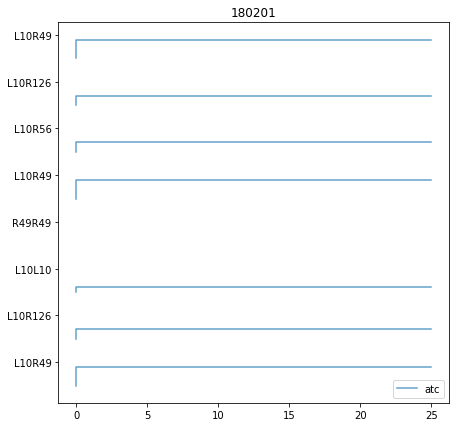

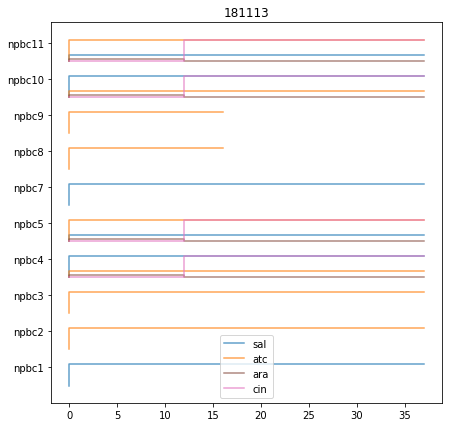

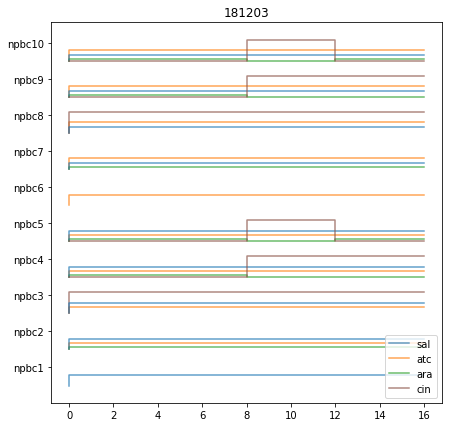

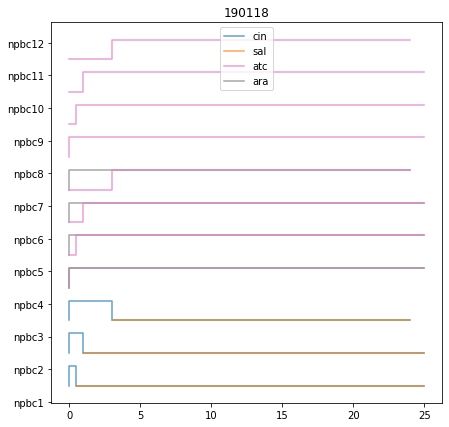

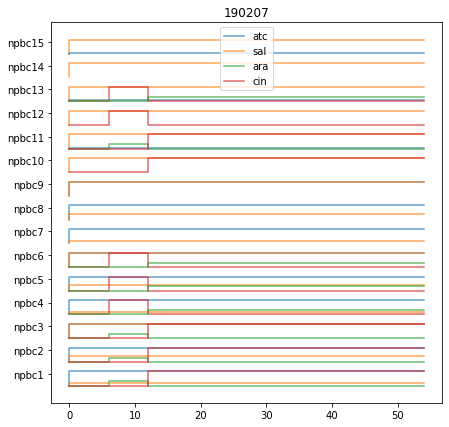

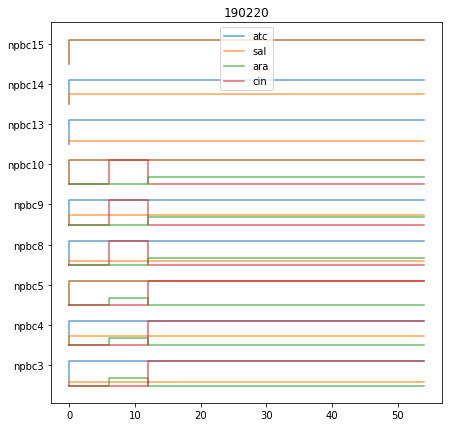

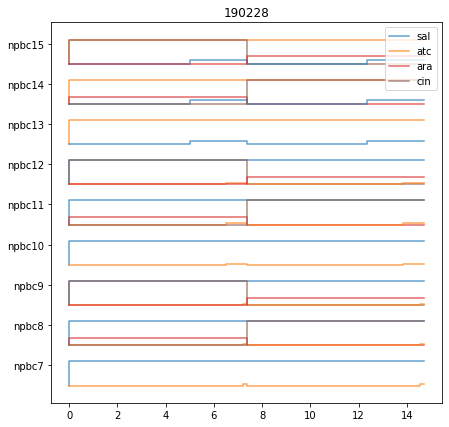

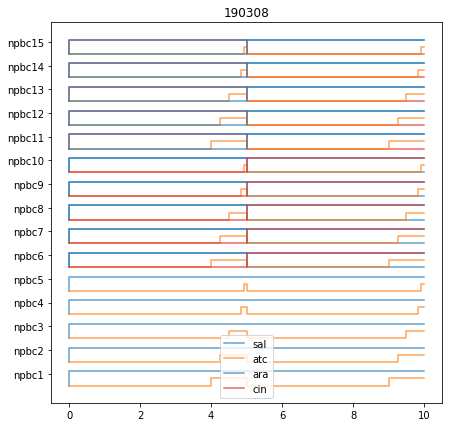

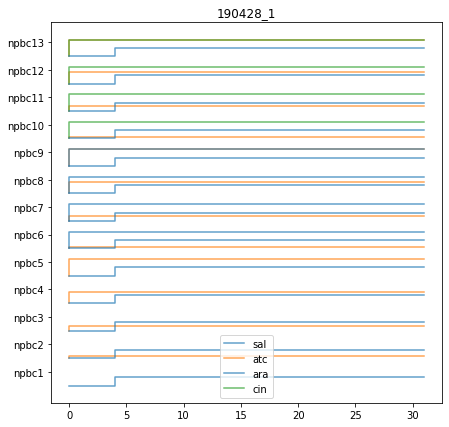

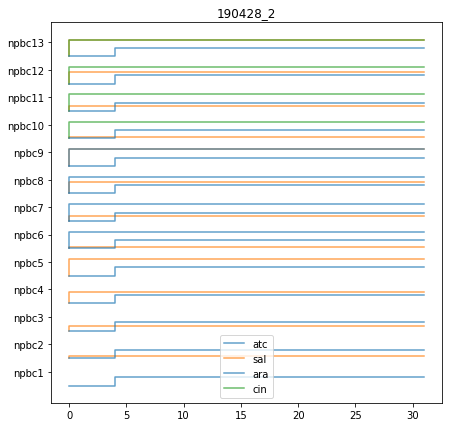

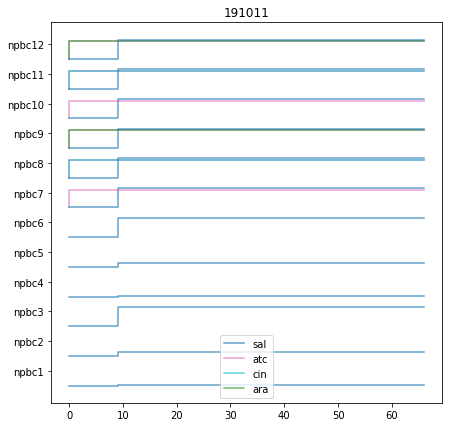

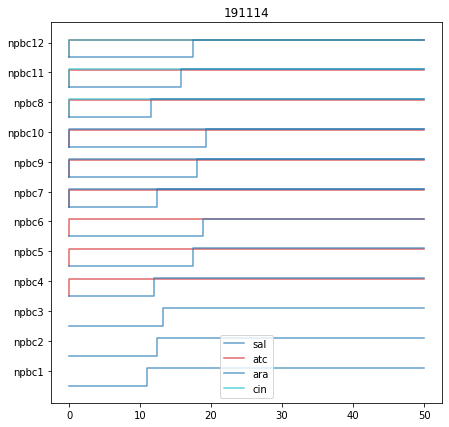

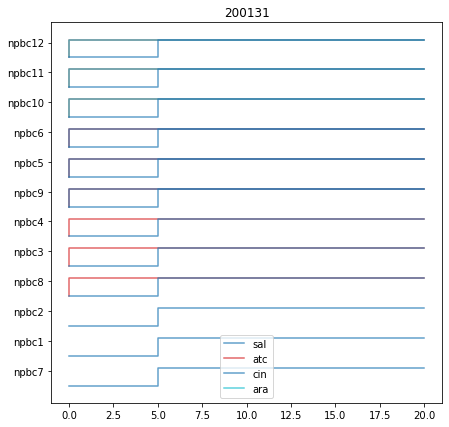

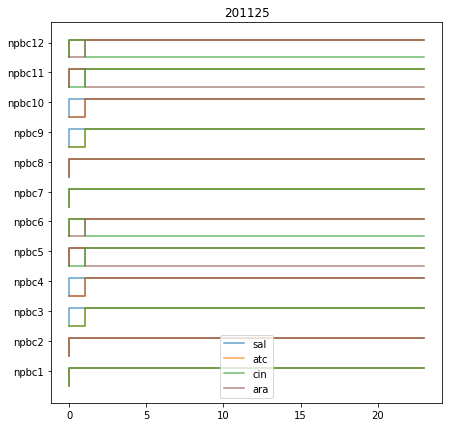

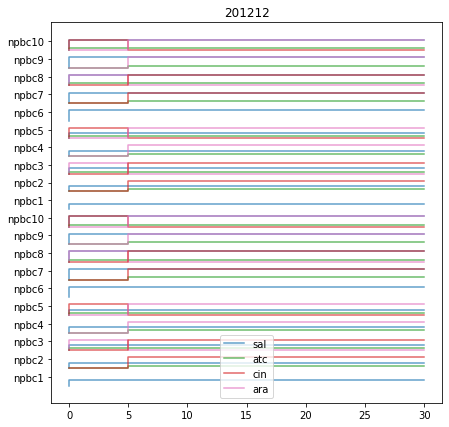

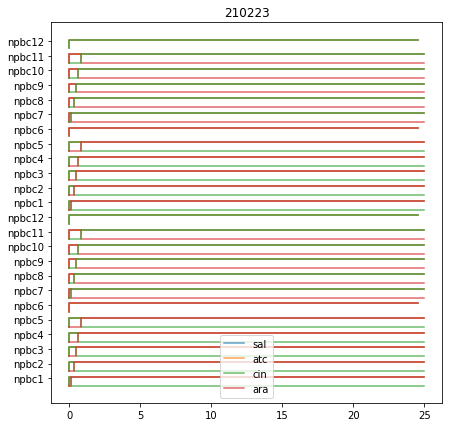

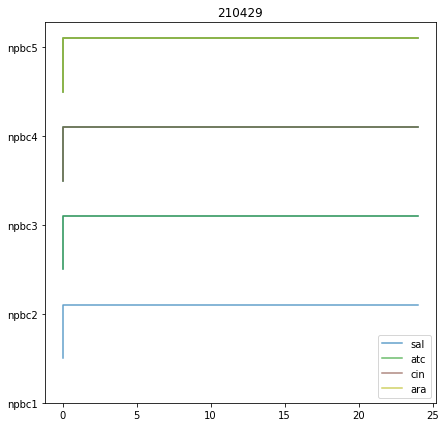

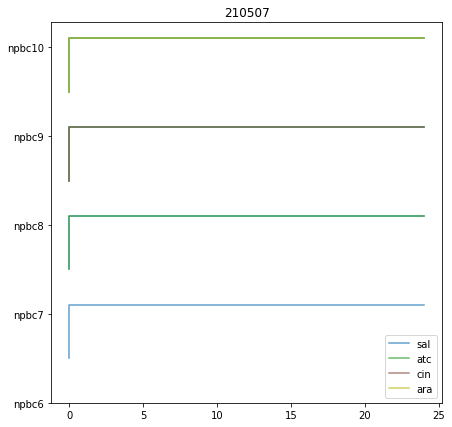

IndexError: single positional indexer is out-of-bounds

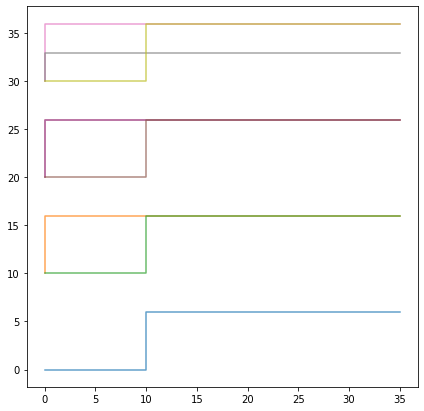

In [84]:
#plot inductions
import numpy as np
import matplotlib.pyplot as plt
def plot_conditions(date,df,inducer_df,exp_height=10,maxinducers=None):
    if(maxinducers is None):
        maxinducers = {"atc":300,"ara":2,"sal":100,"cin":5}
    subdf = df[df["date_sequenced"]==date]
    num_samples = len(subdf)
    totalheight = num_samples*float(exp_height)+exp_height
    startpositions = np.arange(0,num_samples*float(exp_height),exp_height)
    namepositions = startpositions+exp_height/2
    conditions = ["c"+str(a) for a in range(1,5)]
    #print(startpositions)
    #print(namepositions)
    namelist = []
    for barcode,ypos in zip(list(subdf.barcode),startpositions):
        bcdf = subdf[subdf.barcode==barcode]
        inducergraphs = {}
        inducertimes = []
        
        for condition in conditions:
            if(pd.isna(bcdf[condition].iloc[0])):
                pass
            else:
                induction_cond = bcdf[condition].iloc[0]
                time_hr = float(induction_cond.split(",")[0]) #number of hours of this induction condition
                if(len(inducertimes)>=1):
                    time_hr += inducertimes[-1]
                inducertimes += [time_hr]
                inducers = induction_cond.replace("[","").replace("]","").split(",")[1:]
                induceramounts = []
                for inducer in inducers:
                    if(inducer != ""):
                        if("_" in date):
                            newdate = date.split("_")[0]
                        else:
                            newdate = date
                        induceramounts += [inducer_df[inducer_df["inducername"]==inducer][newdate].iloc[0]]
                    else:
                        induceramounts += [0]
                for inducer,amount in zip(inducers,induceramounts):
                    inducer_sanitized = inducer
                    if(inducer==""):
                        continue
                    if(inducer[-1] in ''.join([str(a) for a in range(20)])):
                        #if the inducer has a number at the end of it, chop that off
                        inducer_sanitized = inducer[:-1]
                    if(inducer_sanitized in inducergraphs):
                        #this means the inducer has already been seen
                        if(len(inducergraphs[inducer_sanitized])==len(inducertimes)-1):
                            #this means we only have one time spot to fill
                            inducergraphs[inducer_sanitized]+=[amount]
                        else:
                            #we have to backfill with zeros
                            lendiff = len(inducertimes)-len(inducergraphs[inducer_sanitized])-1
                            inducergraphs[inducer_sanitized]+=[0]*lendiff+[amount]
                        
                        inducertimes += []
                    else:
                        #if the inducer hasn't been seen, then back fill it with zeros
                        inducergraphs[inducer_sanitized] = [0]*(len(inducertimes)-1)+[amount]
        
        for inducer in inducergraphs:
            #pad the ends with zeros in case an inducer ended early
            lendiff = len(inducertimes)-len(inducergraphs[inducer])
            if(lendiff>0):
                inducergraphs[inducer]+= [0]*lendiff
            yvals = np.array(inducergraphs[inducer])*(exp_height*.6)/maxinducers[inducer]+ypos
            yvals = [ypos]+list(yvals)
            xvals = [0]+inducertimes
            #print(xvals)
            #print(yvals)
            plt.step(xvals,yvals,label=inducer,where="pre",alpha=0.7)
            namelist += [inducer]
        #print("done")
        #print(inducertimes)
        #print(inducergraphs)
    plt.title(date)
    plt.yticks(namepositions,labels=list(subdf.barcode))
    ax = plt.gca()
    names = namelist
    for i, p in enumerate(ax.get_lines()):    # this is the loop to change Labels and colors
        if( p.get_label() in names[:i]):    # check for Name already exists
            idx = names.index(p.get_label())       # find ist index
            p.set_c(ax.get_lines()[idx].get_c())   # set color
            p.set_label('_' + p.get_label())       # hide label in auto-legend
        
            
    #plt.figure(figsize=(10,20))
    #print(len(subdf))
datelist = list(df_data["date_sequenced"].unique())
#datelist = ["210223"]

for date in datelist:
    plt.figure(figsize=(7,7))
    plot_conditions(date,df_data,df_inducers)
    plt.legend()
    plt.show()

In [ ]:
import pickle

statsfile = os.path.join("/",datapath,"alldata.pickle")
with open(statsfile,'rb') as saved_file:
    statsdf = pickle.load(saved_file)
statsdf['dataname'] = statsdf.dataname.astype('str')
    
for dataname in statsdf.dataname:
    datanamestr = str(dataname)
    plist = '_'.join(list(df_data[df_data.date_sequenced==datanamestr].primerf.unique()))
    statsdf.loc[statsdf.dataname==dataname,"primerf"]=plist
    plist = '_'.join(list(df_data[df_data.date_sequenced==datanamestr].primerr.unique()))
    statsdf.loc[statsdf.dataname==dataname,"primerr"]=plist
statsdf

In [ ]:
import matplotlib.pyplot as plt


plt.bar(statsdf.dataname,height = statsdf.forward, align="center",label='foward')

plt.bar(statsdf.dataname,height = statsdf.reverse,bottom = statsdf.forward, align="center",label='reverse')

plt.bar(statsdf.dataname,height = statsdf.unknown,bottom = statsdf.forward+statsdf.reverse, align="center",label='unknown')
plt.xticks(rotation=80)
plt.legend()
plt.show()

In [ ]:
datasets = list(df_data.date_sequenced.unique())
induction_df = pd.DataFrame(columns=["datasetname","barcode","time","inducer","inducer_conc"])
for dataset in datasets:
    df_dataset = df_data[df_data.date_sequenced==dataset]
    barcodes = list(df_dataset.barcode.unique())
    for bc in barcodes:
        df_bc = df_dataset[df_dataset.barcode==bc]
        conditions = range(1,5)
        time_acc = 0
        for condition in conditions:
            cond_str = "c"+str(condition)
            cond_data = df_bc[cond_str].iloc[0]
            if(pd.isna(cond_data)):
                induction_df = induction_df.append(pd.DataFrame([[dataset,bc,time_acc,"",0]],\
                            columns=["datasetname","barcode","time","inducer","inducer_conc"]))
                break
            else:
                cond_split = cond_data.split(",",maxsplit=1)
                cond_split[1] = cond_split[1].replace("[","").replace("]","").split(",")
                time_hr = float(cond_split[0])
                #print(cond_split[1])
                for inducer in cond_split[1]:
                    
                    #this part goes through the inducer df to get the right inducer concentration
                    if(inducer==""):
                        #this means we induced with nothing
                        induction_df = induction_df.append(pd.DataFrame([[dataset,bc,time_acc,"none",0]],\
                               columns=["datasetname","barcode","time","inducer","inducer_conc"]))
                    else:
                        ind_concentration = df_inducers[df_inducers.inducername == inducer][int(dataset.split("_")[0])].iloc[0]
                        inducername = inducer
                        if(inducer[-1] in '1234567890'):
                            #if the inducer has a number at the end of it, take that off for the inducer's name
                            inducername = inducer[:-1]

                        induction_df = induction_df.append(pd.DataFrame([[dataset,bc,time_acc,inducername,ind_concentration]],\
                                      columns=["datasetname","barcode","time","inducer","inducer_conc"]))
                time_acc += time_hr

induction_df

In [ ]:
in_date = "201125"

save_barcoded_file="191118_simprec.pickl"
input_conditions_file = "191115_input.csv"


with open(os.path.join("/",datapath,in_date,in_date+"_simprec.pickle"),'rb') as saved_file:
    allseqDict = pickle.load(saved_file)

In [ ]:
import os
import sys
sys.path.append(os.path.join(".","nptools"))
from nanopore_scripts import *
all_lists,run_lists,switch_lists,first_last = countBarcodeStats(allseqDict,chopseqs='none')
stats_counted = [
    (["total 0s in a read","total 1s in a read"],all_lists),
    (["longest P run in a read","longest J run in a read"],run_lists),
    (["PJ", "JP"],switch_lists),
    (["P/J, first","P/J, last"],first_last),
]